# Filter TF network edges by expected counts
Here we filter by significance the human TF interactions in the edge list produced by `construct_edge_list.ipynb`. Significance is determined by comparing the observed edge count to an average edge count produced by randomly shuffling the network. We test three shuffling methods: 
1. 'signature shuffling': this method randomly shuffles the target gene sets linked to each source, then produces a new edge count matrix
2. 'node shuffling': this method reconstructs edges by randomly sampling a source node and target node from a weighted distribution, then drawing an edge between the two
3. 'edge shuffling': this method builds an edge list by randomly sampling (source,target) edges from a weighted distribution. 

Import the required packages

In [2]:
from collections import defaultdict
import numpy as np
import pandas as pd
import random
import os
import statistics 
from scipy.stats import norm
import tqdm

Set a random seed to ensure reproducibility

In [3]:
random.seed(314)

Set default directories
- `input` should be the output directory from `construct_edge_list.ipynb`
- `raw_data` should be the same raw data folder used in `construct_edge_list.ipynb`
- `output` is built with three subdirectories to organize the assertions for benchmarking

In [4]:
input = './edge_constructing_files'
output = './filtered_edge_list'
raw_data = './raw_data'

if not os.path.exists(output): 
    os.mkdir(output)
    os.mkdir(f'{output}/signature_shuffling') 
    os.mkdir(f'{output}/node_weighted')
    os.mkdir(f'{output}/edge_weighted')

Upload edge matrix to a dataframe and format it as a multiindex, where the index is a tuple of (source, target, direction). 

In [ ]:
initial_file = f"{input}/edge_list_unfiltered.csv"

initial_counts = pd.read_csv(initial_file)

initial_sources = initial_counts['source'].unique()
initial_targets = initial_counts['target'].unique()

initial_counts.set_index(["source", "target", "direction"], inplace=True)

## Calculate expected edge counts
The general procedure for filtering expected counts is:
1. Produce a randomly shuffled edge count matrix using one of the below methods
2. Calculate the average and standard deviation of counts for each edge after N iterations
3. Calculate the z-score and p-value of the observed edge counts compared to expected
4. Remove any insignificant counts

Three methods of generating expected counts are provided. To test all three methods, run the cells corresponding to one method, then proceed to "Filter results by expected counts". Repeat for all methods.   


Define the number of trials

In [ ]:
N_TRIALS = 50

### Method 1: Signature shuffling
Shuffle signature sets between source TFs and recalculate counts 

Define the benchmark method

In [ ]:
shuffling_method = 'signature_shuffling'

Upload `tf_transpose.gmt` from `edge_constructing_files`. This creates a dictionary formatted as `tf:[signature1 ... signatureN]`, where each signature is a gene set enriched for that TF.  

In [ ]:
signature_file = f"{input}/tf_transpose.gmt"
signature_sets = defaultdict(set)

with open(signature_file, "r") as file:
    for line in tqdm.tqdm(file):
        tf, *signature = line.strip().split()
        signature_sets[tf] = set(signature)

Upload RummaGEO gene sets -- we need this again to be able to reproduce the edge count matrix.

In [ ]:
def read_gmt(path):
  gmt = {}
  print("Reading {}".format(path))
  with open(path, "r") as file:
    for line in tqdm.tqdm(file):
      # 'id' refers to up or down tag
      signature, id, *tf = line.strip().split()
      gmt[" ".join([signature, id])] = set(tf)

  return gmt

geo_gmt = read_gmt(f"{raw_data}/human-geo-auto.gmt")

Recalculate counts:\
First, shuffle the signature sets between TFs.\
Next, count all edges using the same edge-counting procedure as in construct_edge_list.ipynb. Since we repeat this multiple time, each edge count is actually an array of counts (one count for each iteration):
```
{ source: { 
    target: { 
            '+': np.array(up_counts_all_trials)
            '-': np.array(dn_counts_all_trials)
        }
    }
}
```

In [ ]:
def shuffle_signatures(signature_sets):
    tfs = list(signature_sets.keys())
    sigs = list(signature_sets.values())
    random.shuffle(sigs)
    shuffled_sigsets = dict(zip(tfs, sigs))
    return shuffled_sigsets

all_high_tfs = list(signature_sets.keys())

expected_counts = {source : {target : {
    "+": np.zeros(N_TRIALS),
    "-": np.zeros(N_TRIALS),
  } for target in all_high_tfs} for source in all_high_tfs}

for i in tqdm.tqdm(range(N_TRIALS)):
  shuffled_sets = shuffle_signatures(signature_sets)

  # Calculate counts
  for source in all_high_tfs:
    for signature in shuffled_sets[source]:

      spl = signature.rsplit("-", 1)
      dir = "+" if spl[1] == "up" else "-" # "dn"
      joined_sig = " ".join(spl)

      # if the gene set name is in the keys for the rummaGEO GMT
      if joined_sig in geo_gmt.keys():
        for target in all_high_tfs:
          if target in geo_gmt[joined_sig]: 
            expected_counts[source][target][dir][i] += 1
    
      else:
        raise Exception("Signature {} not found".format(joined_sig))

### Method 2: Node weighted
Randomly generate new edges by randomly selecting (weighted) source and target nodes independently   


Define the benchmark method

In [ ]:
shuffling_method = 'node_weighted'

Find the weighted distribution for source and target nodes by calculating the proportion of all edges that involve a unique node. 

In [ ]:
source_counts = initial_counts.groupby(['source']).sum()
target_counts = initial_counts.groupby(['target']).sum()

source_weights = source_counts['count'].tolist()
target_weights = target_counts['count'].tolist()

num_edges = initial_counts['count'].sum()

source_labels = source_counts.index.tolist()
target_labels = target_counts.index.tolist()

Calculate the expected counts by sampling a set of N random source and target nodes and drawing an edge between each pair, where N = the number of edges in the input edge list. Count the number of times each (source,target) edge occurs. Finally, convert the edge count matrix to a dataframe.

In [ ]:
expected_counts = {source : {target : {
    "+": np.zeros(N_TRIALS),
    "-": np.zeros(N_TRIALS),
  } for target in initial_targets} for source in initial_sources}

for i in tqdm.tqdm(range(N_TRIALS)):
        # Perform weighted random choice
        random_source = random.choices(source_labels, weights=source_weights, k=num_edges)
        random_target = random.choices(target_labels, weights=target_weights, k=num_edges)
          
        for source, target in zip(random_source, random_target):
                # randomly choose an edge direction
                direction = random.randint(0,1)
                if direction == 0:
                        expected_counts[source][target]["+"][i] += 1
                else:
                        expected_counts[source][target]["-"][i] += 1

### Method 3: Edge weighted
Instead of sampling source and target nodes independently, produce a weighted distribution of edges based on their initial counts. Randomly sample N edges, where N is the size of the original edge matrix.

Define the benchmark method

In [ ]:
shuffling_method = 'edge_weighted'

Produce a weighted distribution of edges using their counts in the input edge list. Randomly sample N edges from this distribution, where N is the size of the input edge list. 

In [ ]:
# randomly select N edges from a network using weighted random sampling
# N is the total number of edge counts in the input network
def find_random_edges(network):
        edge_counts = network.groupby(['source', 'target']).sum()
        edge_weights = edge_counts['count'].tolist()
        num_edges = sum(edge_weights)
        edge_labels = edge_counts.index.tolist()
        random_edges = random.choices(edge_labels, weights=edge_weights, k=num_edges)

        return random_edges

# initialize expected counts
expected_counts = {source : {target : {
    "+": np.zeros(N_TRIALS),
    "-": np.zeros(N_TRIALS),
  } for target in initial_targets} for source in initial_sources}

for i in tqdm.tqdm(range(N_TRIALS)):
        # Perform weighted random choice
        random_edges = find_random_edges(initial_counts)     

        for index in random_edges:
                # extract the source, target and randomly assign a direction
                source, target = index

                # randomly choose an edge direction
                direction = random.randint(0,1)

                if direction == 0:
                        expected_counts[source][target]["+"][i] += 1
                else:
                        expected_counts[source][target]["-"][i] += 1

## Filter results using expected counts

First, calculate the edge statistics using the expected counts - observed counts, expected counts, mean, stdev, z-score, and p-value

In [ ]:
# make a similar array to store stats
hindex = pd.MultiIndex.from_product([initial_sources, initial_targets,['+', '-']],
  names = ["source", "target", "relation"])
edge_statistics = pd.DataFrame(index = hindex, columns = ["observed", "expected", "expected stdev", "z-score", "p-value"])

for source in tqdm.tqdm(initial_sources):
  for target in initial_targets:
    for dir in ['+','-']:
      trial_counts = expected_counts[source][target][dir]

      # find expected and observed counts -- if that edge doesn't exist, then the observed counts are zero
      try:
        obsv_counts = initial_counts.loc[(source, target, dir), 'count']
      except KeyError:
        obsv_counts = 0

      # calculate statistics 
      mean = statistics.mean(trial_counts)
      stdev = statistics.stdev(trial_counts)

      # ignore values with no stdev and expected counts == 0
      if mean > 0 and stdev > 0:
        z_score = (obsv_counts - mean) / stdev
        p_value = norm.sf(z_score)

        # store in dataframe, removing non-existent edges
        if obsv_counts > 0:
          edge_statistics.loc[(source, target, dir)] = [obsv_counts, mean, stdev, z_score, p_value]

In [ ]:
# make a similar array to store stats
hindex = pd.MultiIndex.from_product([initial_sources, initial_targets,['+', '-']],
  names = ["source", "target", "relation"])
edge_statistics = pd.DataFrame(index = hindex, columns = ["observed", "expected", "expected stdev", "z-score", "p-value"])

for source in tqdm.tqdm(initial_sources):
  for target in initial_targets:
    for dir in ['+','-']:
      trial_counts = expected_counts[source][target][dir]

      # find expected and observed counts -- if that edge doesn't exist, then the observed counts are zero
      try:
        obsv_counts = initial_counts.loc[(source, target, dir), 'count']
      except KeyError:
        obsv_counts = 0

      # calculate statistics 
      mean = statistics.mean(trial_counts)
      stdev = statistics.stdev(trial_counts)

      # ignore values with no stdev and expected counts == 0
      if mean > 0 and stdev > 0:
        z_score = (obsv_counts - mean) / stdev
        p_value = norm.sf(z_score)

        # store in dataframe, removing non-existent edges
        if obsv_counts > 0:
          edge_statistics.loc[(source, target, dir)] = [obsv_counts, mean, stdev, z_score, p_value]


Remove insignificant edges.

In [ ]:
# drop NAs
edge_statistics.dropna(inplace=True)

p_sorted = edge_statistics.sort_values(by='p-value', ascending = True)
P = 0.01
significant_edges = edge_statistics.loc[edge_statistics['p-value'] < P]

edges = significant_edges.index.to_frame(index=False)
print(f"Network type is {shuffling_method}")
print("Number of edges is ", len(edges))

targets = edges['target'].value_counts()
sources = edges['source'].value_counts()
allnodes = set(targets.index.to_list()) | set(sources.index.to_list())
print(f"Number of nodes is: {len(allnodes)}")

avg_in = statistics.mean(edges['target'].value_counts())
avg_out = statistics.mean(edges['source'].value_counts())
print("The average target degree is: ", avg_in)
print("The average source degree is: ", avg_out)

For pairs that have significant edges in both directions, keep only the edge with the most significance.

In [ ]:
# work from a copy
significant_edges_copy = significant_edges.copy()
edges_to_drop = []

# search source-target pairs and retain only the edge with the highest significance 
for (source, target), group in significant_edges_copy.groupby(level=['source', 'target']):

    directions = group.index.get_level_values('relation')

    # remove either up or down if both are significant
    if '+' in directions and '-' in directions:
        # Filter to get '+' and '-' entries
        up_data = group.loc[(slice(None), slice(None), '+'), :]
        dn_data = group.loc[(slice(None), slice(None), '-'), :]   

        # remove lower z-score
        if up_data['z-score'].values[0] > dn_data['z-score'].values[0]:
          edges_to_drop.append((source, target, '+')) 
        else:
          edges_to_drop.append((source, target, '-'))

significant_edges_copy.drop(edges_to_drop, inplace=True)

To get a sense of the size of our network after filtering, let's look at the edge count as well as the distribution of node degrees for source and for target nodes. For more detailed network statistics, run `network_stats.py` on the KG-formatted network assertions.

In [ ]:
edges = significant_edges_copy.index.to_frame(index=False)
print(f"Network type is {shuffling_method}")
print("Number of edges is ", len(edges))

targets = edges['target'].value_counts()
sources = edges['source'].value_counts()
allnodes = set(targets.index.to_list()) | set(sources.index.to_list())
print(f"Number of nodes is: {len(allnodes)}")

avg_in = statistics.mean(edges['target'].value_counts())
avg_out = statistics.mean(edges['source'].value_counts())
print("The average target degree is: ", avg_in)
print("The average source degree is: ", avg_out)

Save large edge list

In [ ]:
p_sorted.to_csv(f"{output}/large/{shuffling_method}/p_sorted_edge_stats.csv", sep='\t')

**For demo network only:** 
In order to prevent the final network from being too dense to visualize, limit the maximum number of outgoing ('source') edges.

In [ ]:
# keep only the top 3 most significant edges from each source \n",
max_src_edges = 3
significant_edges_copy.sort_values(by=['source','z-score'], inplace=True)
significant_edges_copy.groupby(level='source')
significant_edges_copy.to_csv(f"{output}/large/{shuffling_method}/edge_list_filtered.csv")


In [ ]:
final_edge_list = significant_edges_copy.groupby(level='source').head(max_src_edges)
final_edge_list.to_csv(f"{output}/small/{shuffling_method}/edge_list_filtered.csv")

Basic network statistics including number of unique nodes and edges by type, average links per node, and number of self loops and feedback loops are defined in the module `network_statistics.py`. Ideally there are only a few thousand edges, with only a few average links per node. These criteria will make visualizing the whole network much easier, but are not required.

Additionally, plot the connectivity distribution of the network nodes.

                                              0
Total nodes                         1550.000000
Unique source nodes                  701.000000
Unique target nodes                 1549.000000
Total edges                        53066.000000
Number of up edges                 24196.000000
Number of dn edges                 28870.000000
Avg in links per node                 34.258231
Avg out links per node                75.700428
Avg total links per node              34.236129
Number of self loops                 105.000000
Number of positive feedback loops    496.000000
Number of negative feedback loops    316.000000


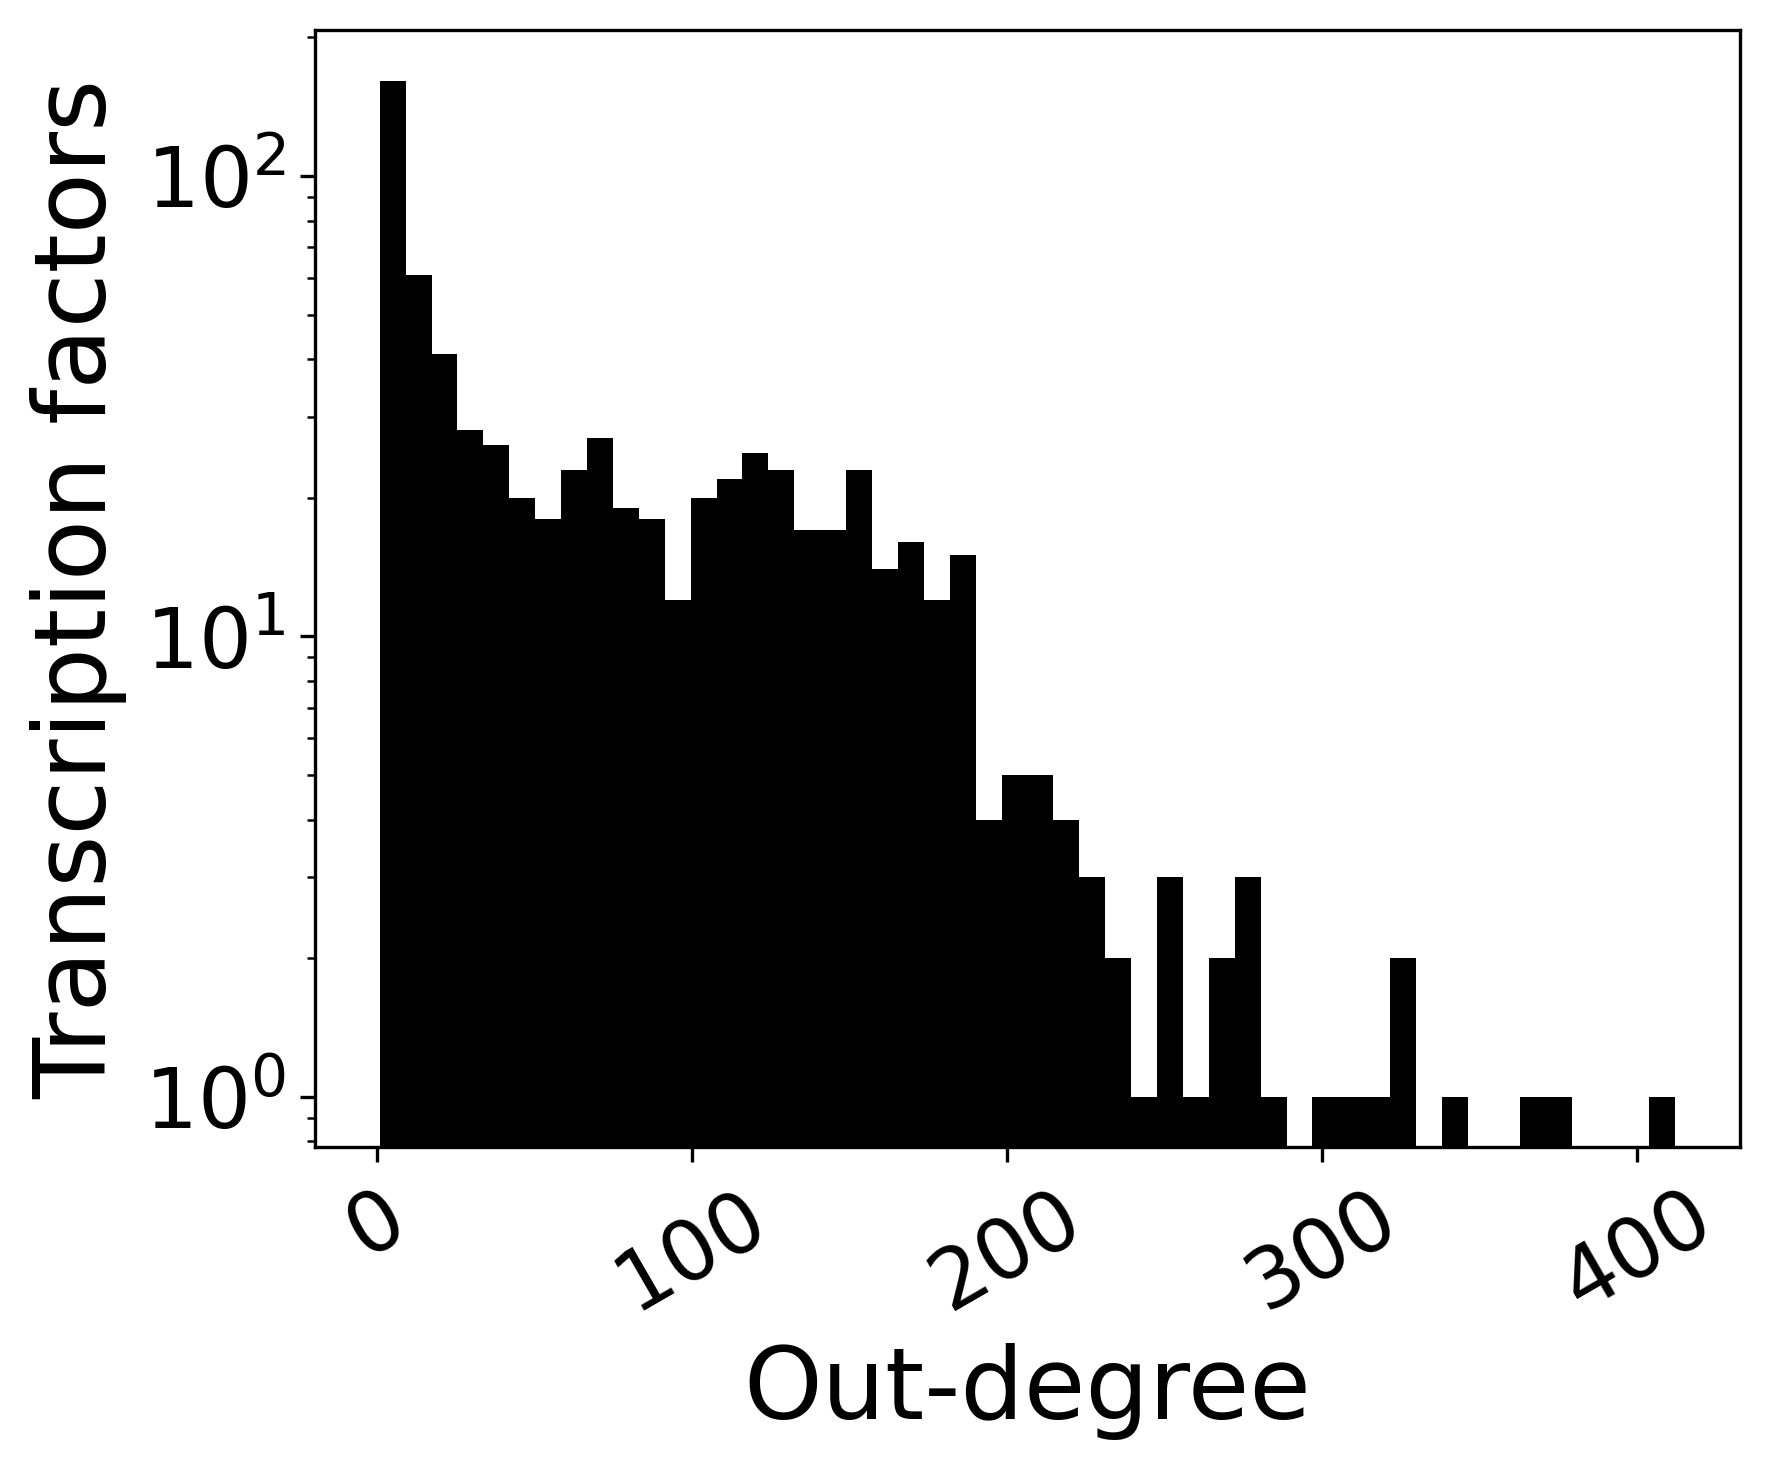

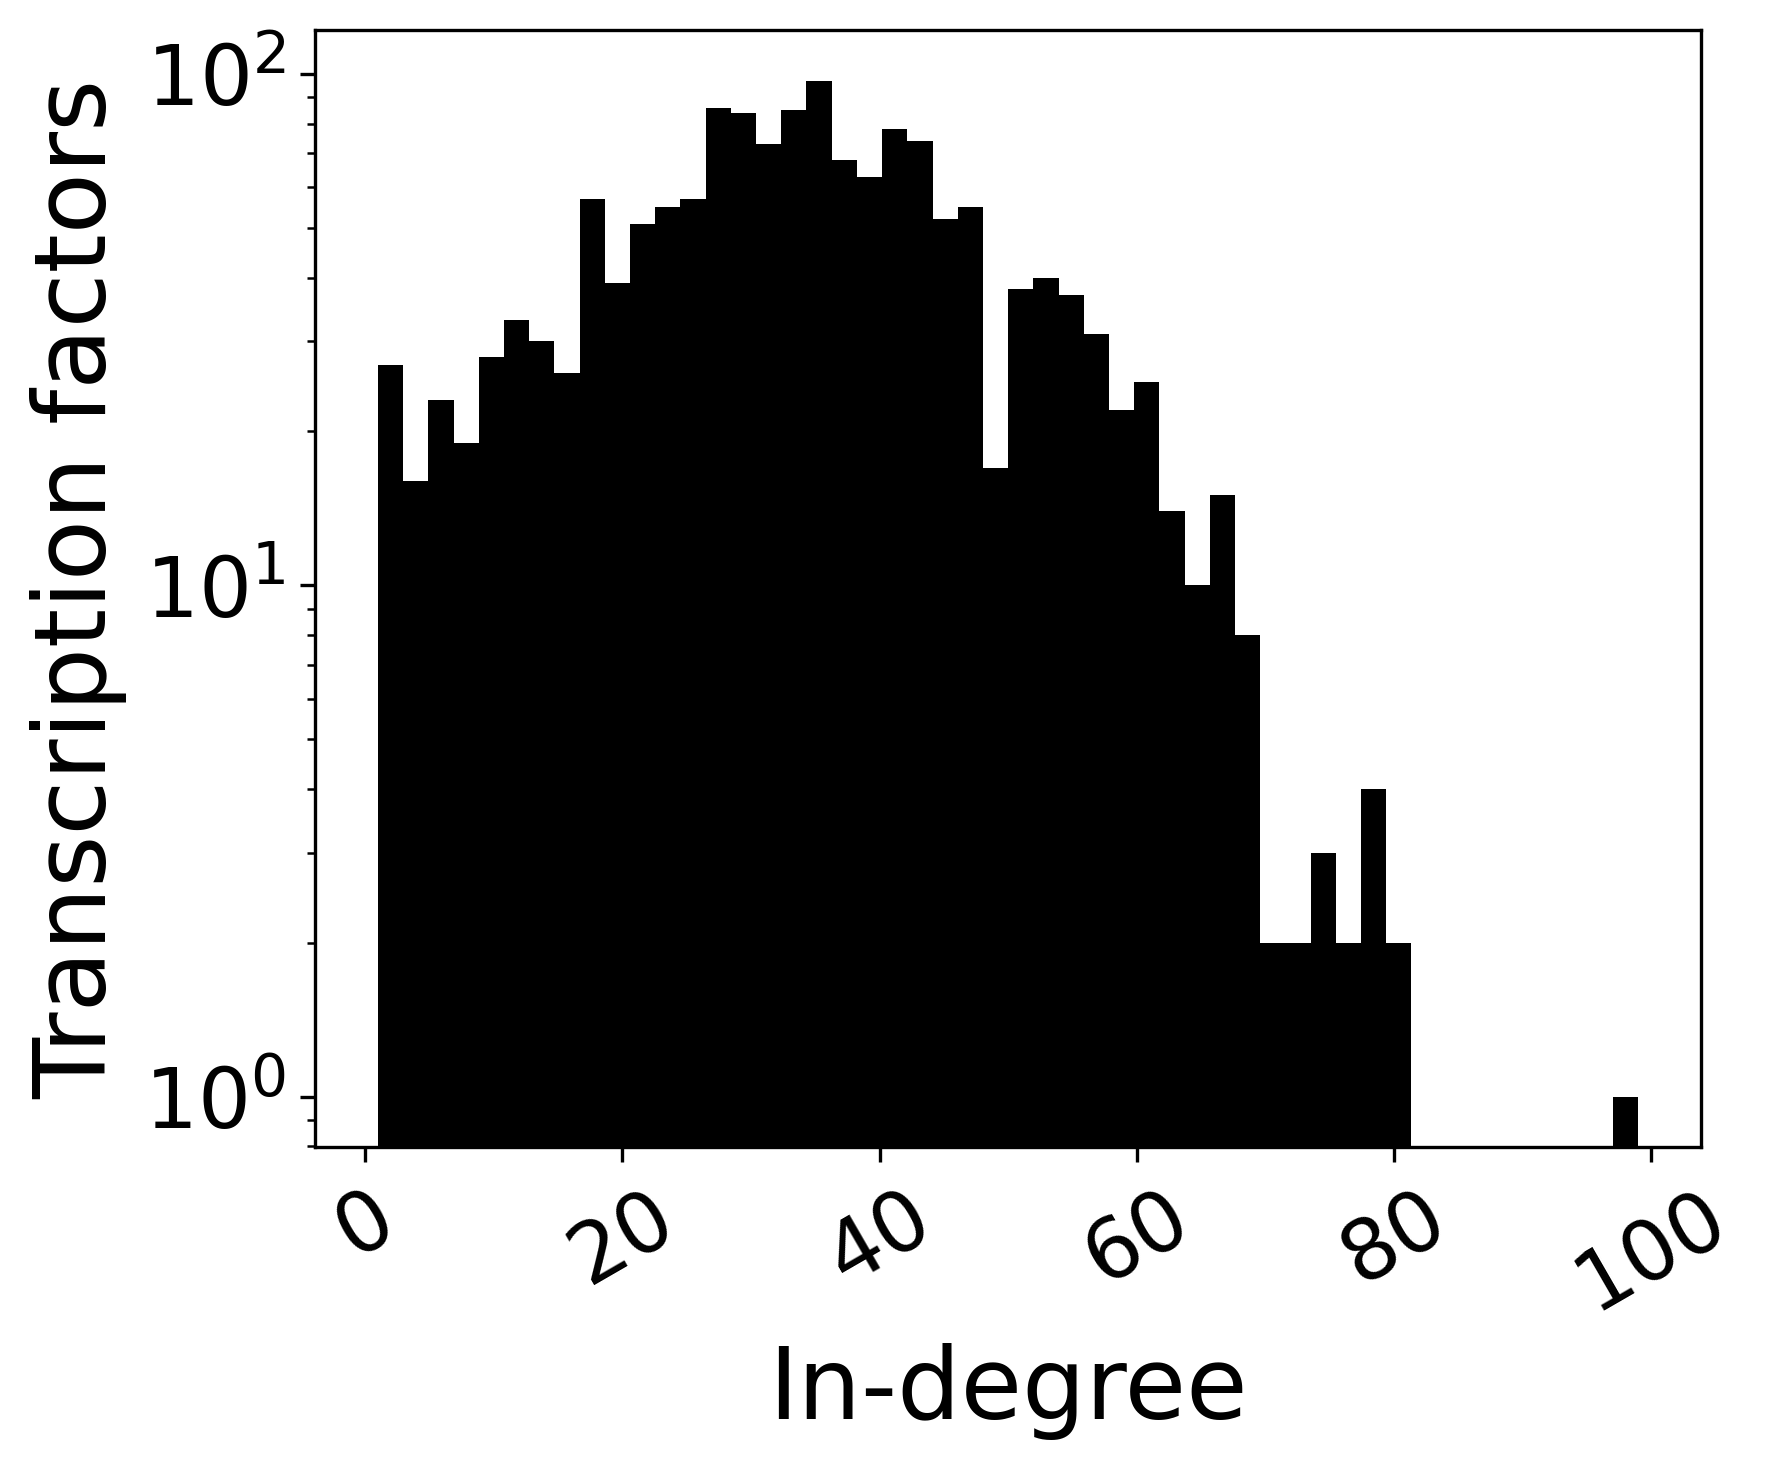

In [7]:
import network_statistics as nstats
import importlib
importlib.reload(nstats)
shuffling_method = 'edge_weighted'
outfile = f"{output}/large/{shuffling_method}/edge_list_filtered.csv"
nstats.all_network_stats(outfile)
nstats.plot_connectivity_distrib(outfile, f'{output}/large/{shuffling_method}')